In [1]:
using PyPlot

In [2]:
abstract Kernel

# squared exponential kernel
type SEKernel <: Kernel
    params::AbstractArray # log(σ_f^2), log(l^2), log(σ_y^2)
    SEKernel(l::Float64,σ::Float64,σy::Float64) = new([log(σ^2); log(l^2); log(σy^2)])
    SEKernel(params::AbstractArray) = new(params)
end

# kernel defintion for SE kernel
function kern(se::SEKernel, x::AbstractArray,x_::AbstractArray)
    diff = x - x_
    k = exp(se.params[1]) * exp(-diff'*diff/(2*exp(se.params[2])))[1]
    return k
end

# dk/dx (not x_)
function d_kern(se::SEKernel, x::AbstractArray,x_::AbstractArray)
    δ = x - x_
    result =  -exp(se.params[1]) * δ * exp(-δ'*δ/(2exp(se.params[2]))) / exp(se.params[2])
    return result[1]
end

# d^2k/dx^2 (not x_)
function d2_kern(se::SEKernel, x::AbstractArray,x_::AbstractArray)
    δ = x - x_
    outer_product = δ*δ'
    result =  -(eye(outer_product) - outer_product/exp(se.params[2]))* exp(se.params[1]) * exp(-δ'*δ/(2exp(se.params[2])))/exp(se.params[2])
    return result[1]
end

# d^3k/dx^3 (not x_)
# note that we assume that x and x_ are
# 1x1 arrays here so we don't have to return a tensor!
function d3_kern(se::SEKernel, x::AbstractArray,x_::AbstractArray)
    δ = x - x_
    return (exp(se.params[1]) * (3δ - δ^3/exp(se.params[2])) * exp(-δ'*δ/(2exp(se.params[2])))[1] / exp(se.params[2])^2)[1]
end

# create convariance matrix K
# X,X_ have rows of data points
function K(kernel::Kernel, X::AbstractArray,X_::AbstractArray)
    K_ = zeros(size(X)[1], size(X_)[1])
    for i=1:size(K_)[1]
        for j=1:size(K_)[2]
            @inbounds K_[i,j] = kern(kernel, X[i,:], X_[j,:])
        end
    end
    if size(K_)[1] == size(K_)[2] && typeof(kernel) == SEKernel
        K_ += exp(kernel.params[3])*eye(K_)
    end
    return K_
end
function d_K(kernel::Kernel, X::AbstractArray,X_::AbstractArray)
    K_ = zeros(size(X)[1], size(X_)[1])
    for i=1:size(K_)[1]
        for j=1:size(K_)[2]
            @inbounds K_[i,j] = -d_kern(kernel, X[i,:], X_[j,:])
        end
    end
    return K_
end
function d2_K(kernel::Kernel, X::AbstractArray,X_::AbstractArray)
    K_ = zeros(size(X)[1], size(X_)[1])
    for i=1:size(K_)[1]
        for j=1:size(K_)[2]
            @inbounds K_[i,j] = d2_kern(kernel, X[i,:], X_[j,:])
        end
    end
    return K_
end
function d3_K(kernel::Kernel, X::AbstractArray,X_::AbstractArray)
    K_ = zeros(size(X)[1], size(X_)[1])
    for i=1:size(K_)[1]
        for j=1:size(K_)[2]
            @inbounds K_[i,j] = -d3_kern(kernel, X[i,:], X_[j,:])
        end
    end
    return K_
end

function K(se::SEKernel, x::Float64,x_::Float64)
    return kern(se, [x], [x_])
end

K (generic function with 2 methods)

__Algorithm 15.1:__ GP regression:
(Murphy pp. 526)
1. $L = \mathrm{cholesky}(K + \sigma_y^2 I)$
2. $\alpha = L^T \backslash (L \backslash y)$
3. $\mathbb{E}[f_*] = k_8^T\alpha$
4. $v = L \backslash k_*$
5. $\mathrm{var}[f_*] = \kappa(x_*,x_*) - v^Tv$
6. $\log p(y|X) = -\frac{1}{2}y^T\alpha - \sum_i \log L_{ii} - \frac{N}{2}\log(2\pi)$

In [3]:
σ = 2.
l = 0.75
σ_y = 1.5
se = SEKernel(l,σ,σ_y)

# define some fake data

t = collect(0:0.5:10)
y_true = t.*sin(0.25*2π*t) + t
y = y_true + randn!(zeros(t))*2


println("==> Construct Kernels")
t_ = collect(-1:0.01:15)
K_ = K(se, t, t)

k_ = K(se, t, t_)
k__ = K(se, t_,t_)


println("==> Run GP Regression")
# GP Regression algorithm
# -- Machine Learning: A Probabalistic Perspective
#    Kevin Murphy, pp. 526
L = chol(K_)
α = L'\(L\y)
μ = k_'*α
v = L'\k_
σ = sqrt(diag(k__) - diag(v'*v))
logP = -y'*α/2 - sum(log(diag(L))) - size(y)[1]*log(2π)/2
println("--  done.")
println("==> Marginal Likelihood: log P(y|X) = $(logP[1])")

==> Construct Kernels
==> Run GP Regression
--  done.
==> Marginal Likelihood: log P(y|X) = -95.27477553008154


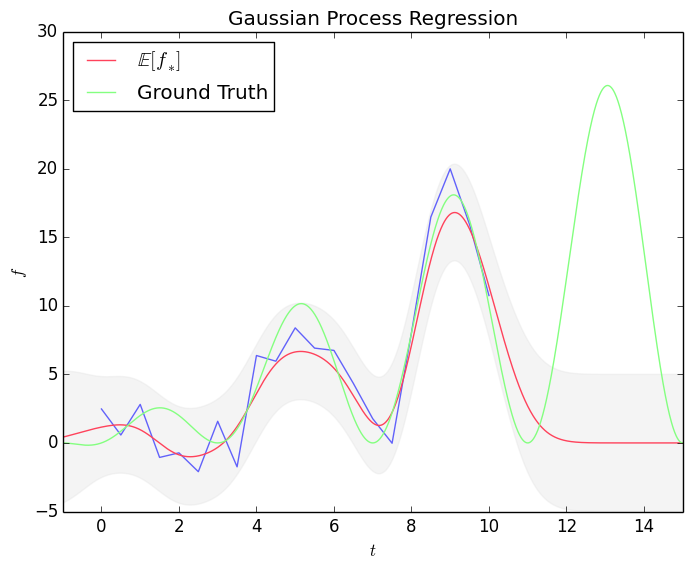

(-1,15)

In [4]:
plot(t,y, alpha=0.6) #label="\$f(t) = t\\sin(\\pi t/2) + t + \\epsilon\$", alpha=0.6)
plot(t_, μ, label="\$\\mathbb{E}[f_*]\$", color="#FF425B")
fill_between(t_, μ-2σ, μ+2σ, color="#dddddd", alpha=0.3)
plot(t_, t_.*sin(0.25*2π*t_) + t_, label="Ground Truth", color="#84FF80")
title("Gaussian Process Regression")
xlabel("\$t\$")
ylabel("\$f\$")
legend(loc="upper left")

xlim(-1,15)

(Murphy pp. 520)

Our Gaussian Process is given by the joint density

$$
    \begin{pmatrix}y\\f_* \end{pmatrix} \sim \mathcal{N}\left( 0, \begin{pmatrix} K_y & K_* \\ K_*^T & K_{**} \end{pmatrix} \right) 
$$

Note we assume the mean $\mu = 0$. Then our posterior predictive distribution is given by

$$
\begin{align*}
    p(f_*|x_*,X,y) &= \mathcal{N}(f_*|\mu_*,\Sigma_*)\\
    \mu &= K_*^TK_y^{-1}y\\
    \Sigma_* &= K_{**} - K_*^TK_y^{-1}K_*
\end{align*}
$$

When we have a single test input this becomes

$$
    p(f_*|x_*,X,y) = \mathcal{N}(f_*| k_*^TK_y^{-1}y,\; k_{**} - k_*^TK_y^{-1}k_*),
$$

where the posterior mean can be written

$$
    \overline f_* = k_*^TK_y^{-1}y = \sum_{i=1}^N \alpha_i \kappa(x_i, x_*)\qquad\alpha = K_y^{-1}y
$$

This gives the first derivative

$$
    \frac{\partial \overline f_*}{\partial x_*} = \sum_{i=1}^N \alpha_i \kappa'(x_i,x_*),
$$

For our Squared Exponential Kernel,

$$
    \kappa(x,x') = \sigma_f^2 \exp\left( -\frac{1}{2}(x-x')^T\Lambda^{-1}(x-x') \right) = \sigma_f^2 \exp\left( -\frac{1}{2}||x-x' ||_{\Lambda^{-1}}^2 \right).
$$

We have can differentiate this, as shown in ([Andrew McHutchon 2013](http://mlg.eng.cam.ac.uk/mchutchon/DifferentiatingGPs.pdf) pp. 6), giving (with the third derivative in one dimension $x\in\mathbb{R}$ to avoid a tensor)

$$
\begin{align*}
    \frac{\partial \kappa(x,x')}{\partial x} &= -\sigma_f^2\Lambda^{-1}(x-x')\exp\left(-\frac{1}{2}||x-x'||_{\Lambda^{-1}}^2\right)\\
                                             &= -\Lambda^{-1}(x-x')\kappa(x,x')\\
    \frac{\partial^2 \kappa(x,x')}{\partial x^2} &= -\Lambda^{-1}\left(I - \Lambda^{-1}(x-x')(x-x')^T\right)\kappa(x,x')\\
    \frac{\partial^3 \kappa(x,x')}{\partial x^3} &= \lambda^{-1}\left[ 3(x-x') - \lambda^{-1}(x-x')^3 \right]\kappa(x,x')\\
\end{align*}
$$

==> Construct Kernels
==> Run GP Regression with Derivatives
--  done.
==> Marginal Likelihood: log P(y|X) = -92.50921678845933
==> Plot Results


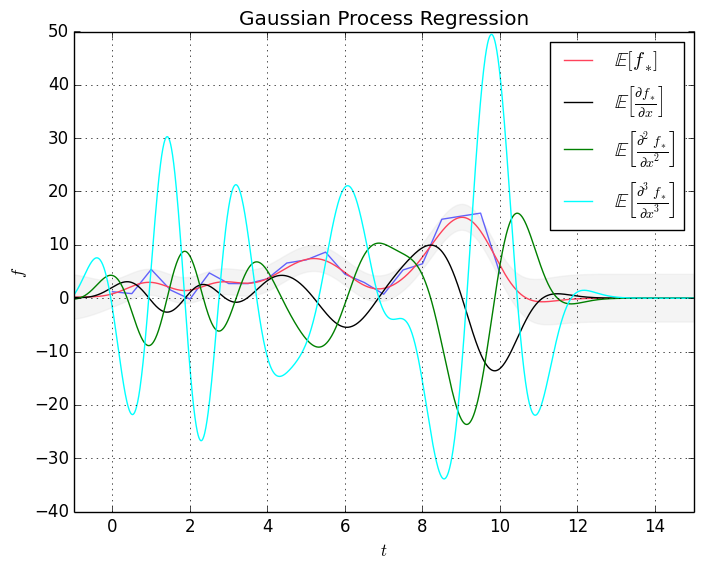

(-1,15)

In [5]:
# define some fake data

t = collect(0:0.5:10)
y_true = t.*sin(0.25*2π*t) + t
y = y_true + randn!(zeros(t))*2

println("==> Construct Kernels")
σ = 2.
l = 0.75
σ_y = 1.
se = SEKernel(l,σ,σ_y)

t_ = collect(-1:0.01:15)
K_ = K(se, t, t)

k_ = K(se, t, t_)
dk_ = d_K(se,t,t_)
d2k_ = d2_K(se,t,t_)
d3k_ = d3_K(se,t,t_)
k__ = K(se, t_,t_)


println("==> Run GP Regression with Derivatives")
# GP Regression algorithm + derivatives
# -- Machine Learning: A Probabalistic Perspective
#    Kevin Murphy, pp. 526
L = chol(K_)
α = L\(L'\y)
μ = k_'*α
dμ = dk_'*α
d2μ = d2k_'*α
d3μ = d3k_'*α
v = L'\k_
σ = sqrt(diag(k__) - diag(v'*v))
logP = -y'*α/2 - sum(log(diag(L))) - size(y)[1]*log(2π)/2
println("--  done.")
println("==> Marginal Likelihood: log P(y|X) = $(logP[1])")

println("==> Plot Results")
plot(t,y, alpha=0.6)
plot(t_, μ, label="\$\\mathbb{E}[f_*]\$", color="#FF425B")
plot(t_, dμ, label="\$\\mathbb{E}\\left[\\frac{\\partial f_*}{\\partial x}\\right]\$", color="black")
plot(t_, d2μ, label="\$\\mathbb{E}\\left[\\frac{\\partial^2 f_*}{\\partial x^2}\\right]\$", color="green")
plot(t_, d3μ, label="\$\\mathbb{E}\\left[\\frac{\\partial^3 f_*}{\\partial x^3}\\right]\$", color="cyan")
fill_between(t_, μ-2σ, μ+2σ, color="#dddddd", alpha=0.3)
#plot(t_, t_.*sin(0.25*2π*t_) + t_, label="Ground Truth", color="#84FF80")
title("Gaussian Process Regression")
xlabel("\$t\$")
ylabel("\$f\$")
legend(loc="upper right")

grid()

xlim(-1,15)

### Financial Data

In [6]:
using DataFrames
using Dates # will throw warning for some reason

In [7]:
tsla_raw = readtable("../data/raw/financial/tsla.csv")

tsla_raw[:_Date] = Date(tsla_raw[:_Date],"d-u-y")

tsla_raw[:Date] = [Float64(datetime2rata(DateTime(date))) for date in tsla_raw[:_Date]]

sort!(tsla_raw, cols=[:Date])

head(tsla_raw)

,_Date,Open,High,Low,Close,Volume,Date
1,0015-05-05,237.76,239.5,229.13,232.95,5796873,5238.0
2,0015-05-06,234.1,234.47,228.2,230.43,5270933,5239.0
3,0015-05-07,221.0,237.48,220.25,236.8,9455909,5240.0
4,0015-05-08,235.99,238.41,233.7,236.61,4668236,5241.0
5,0015-05-11,236.29,242.88,235.31,239.49,5672262,5244.0
6,0015-05-12,240.11,246.35,238.19,244.74,6363429,5245.0


In [8]:
t    = collect(tsla_raw[:Date])
t    = (t - mean(t)) / std(t)
tsla = collect(tsla_raw[:Open])
tsla = (tsla - mean(tsla)) / std(tsla)
t_   = collect(minimum(t):1e-2:maximum(t))

println("==> Run GP Regression over TSLA Open Prices")
println("--  between May 5, 2015 and May 4, 2016")

σ = 0.75
l = 0.2
σ_y = 0.2
se = SEKernel(l,σ,σ_y)

println("==> Construct Kernels")
K_ = K(se, t, t)

k_ = K(se, t, t_)
dk_ = d_K(se,t,t_)
d2k_ = d2_K(se,t,t_)
k__ = K(se, t_,t_)

println("--  done.")

==> Run GP Regression over TSLA Open Prices
--  between May 5, 2015 and May 4, 2016
==> Construct Kernels
--  done.


In [9]:
println("==> Run GP Regression with Derivatives")
# GP Regression algorithm + derivatives
# -- Machine Learning: A Probabalistic Perspective
#    Kevin Murphy, pp. 526
L = chol(K_)
α = L\(L'\tsla)
μ = k_'*α
dμ = dk_'*α
d2μ = d2k_'*α
v = L'\k_
σ = sqrt(diag(k__) - diag(v'*v))
logP = -tsla'*α/2 - sum(log(diag(L))) - size(tsla)[1]*log(2π)/2
println("--  done.")
println("==> Marginal Likelihood: log P(y|X) = $(logP[1])")

==> Run GP Regression with Derivatives
--  done.
==> Marginal Likelihood: log P(y|X) = -84.39008409897264


==> Plot Results


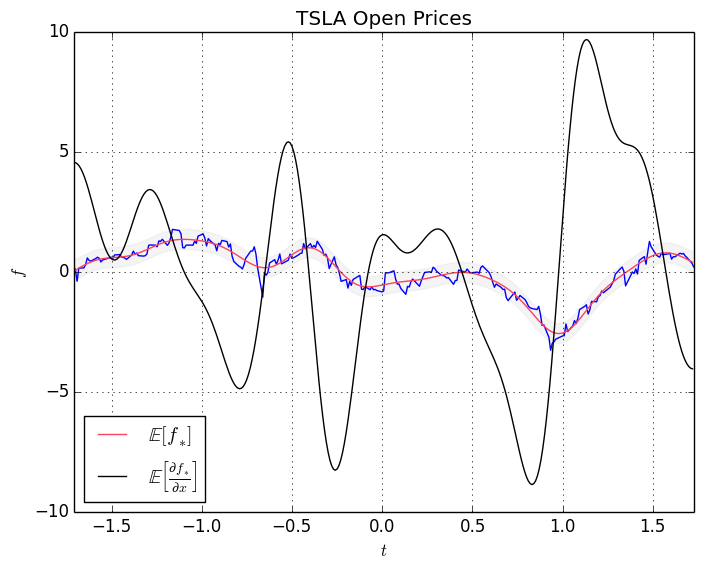

(-1.7101709607151185,1.7265814083171187)

In [10]:
println("==> Plot Results")
plot(t,tsla)
plot(t_, μ, label="\$\\mathbb{E}[f_*]\$", color="#FF425B")
plot(t_, dμ, label="\$\\mathbb{E}\\left[\\frac{\\partial f_*}{\\partial x}\\right]\$", color="black")
#plot(t_, d2μ, label="\$\\mathbb{E}\\left[\\frac{\\partial^2 f_*}{\\partial x^2}\\right]\$")
fill_between(t_, μ-2σ, μ+2σ, color="#dddddd", alpha=0.3)
title("TSLA Open Prices")
xlabel("\$t\$")
ylabel("\$f\$")
legend(loc="lower left")

grid()
xlim(minimum(t), maximum(t))

### Numerical Gradient Check

Check the first derivative numerically off of the mean. Check the second derivative numerically off of the analytic first derivative.

In [11]:
eps = 0.1
println("Checking First and Second Derivatives with ϵ=$(eps)")
for i=2:Integer(floor(size(t_)[1]/10)):size(t_)[1]
    pass = true
    
    # check first derivative
    if abs(dμ[i] - (μ[i+1]-μ[i-1])/(t_[i+1]-t_[i-1])) > eps
        pass = false
    end
    
    # check second derivative
    if abs(d2μ[i] - (dμ[i+1]-dμ[i-1])/(t_[i+1]-t_[i-1])) > eps
        pass = false
    end
    
    if pass
        println("t=$(t_[i])\t [√]")
    else
        println("t=$(t_[i])\t [x]")
    end
end

Checking First and Second Derivatives with ϵ=0.1
t=-1.7001709607151185	 [√]
t=-1.3601709607151184	 [√]
t=-1.0201709607151184	 [√]
t=-0.6801709607151185	 [x]
t=-0.34017096071511843	 [x]
t=-0.00017096071511857325	 [√]
t=0.3398290392848813	 [√]
t=0.6798290392848816	 [√]
t=1.0198290392848814	 [x]
t=1.3598290392848817	 [√]
t=1.6998290392848816	 [√]


### Finding Critical Points

We use Newton's Method to find critical points of the time series, where $\mathbb{E}\left[\frac{\partial f^*}{\partial x}\right] = 0$. We first approximate $f$ quadratically about our current guess $x_n$:

$$
    f \approx f(x_n) + \nabla f(x_0)^T(x-x_n) + \frac{1}{2}(x-x_n)^T\nabla^2 f(x_0)(x-x_n).
$$

where $\nabla^2 f(x_n)$ is the Hessian of $f$ at $x_n$. Now, we find the critical point $x_{n+1}$ from our current quadratic approximation of $f$. Taking the first derivative we find

$$
\begin{align*}
    \frac{\partial f}{\partial x} &= \nabla f(x_n) + \nabla^2 f(x_0)(x-x_n) = 0\\
    x_{n+1} &= x_n - \nabla^2 f(x_n)^{-1}\nabla f(x_n),
\end{align*}
$$

giving us our desired update rule.


Algorithm 2: Newton-Raphson Method
1. Input: Initial Guess $x_0$
2. Repeat Until Convergence ( $||\nabla f(x_n)||_2 \leq \epsilon$ ):
  3. $x_{n+1} = x_n - \nabla^2 f(x_n)^{-1}\nabla f(x_n)$
4. Output Optimal $x_{n+1}$

In [31]:
# find critical points of TSLA data

ϵ = 1e-6 # convergence tolerance
N = 50   # number of starting points
t_opt = maximum(t)*2*(rand(N,1)-0.5)

∇f  = d_K(se,t,t_opt)'*α
∇2f = d2_K(se,t,t_opt)'*α

i  = 0
@time while any(∇f.*∇f .> ϵ^2) && i < 100
    t_opt = t_opt - ∇f ./ ∇2f
    
    if i > 5
        # drop points that aren't converging quickly
        t_opt = t_opt[∇f - mean(∇f) .< 2std(∇f)]
        
        # remove any of t out of the range of data
        t_opt = t_opt[!(t_opt .> maximum(t))]
        t_opt = t_opt[!(t_opt .< minimum(t))]
    end
    
    ∇f  = d_K(se,t,t_opt)'*α
    ∇2f = d2_K(se,t,t_opt)'*α
    
    i = i+1
end

println("==> Done.")
println("--  Steps:   $(i)")
println("--  Maximum? $(∇2f[1] < 0)")

  0.479888 seconds (6.29 M allocations: 284.126 MB, 8.57% gc time)
==> Done.
--  Steps:   7
--  Maximum? false


In [32]:
unique(t_opt)

19-element Array{Float64,1}:
 -0.0683816
  0.442814 
 -0.0683816
  1.57425  
  0.977516 
 -0.408594 
 -1.08562  
 -0.0683816
  0.442814 
 -1.08562  
  0.442814 
 -0.652616 
 -1.08562  
 -0.652616 
 -1.08562  
 -0.408594 
 -0.652616 
 -0.0683816
 -0.0683816

==> Plot Results of Critical Point Optimization


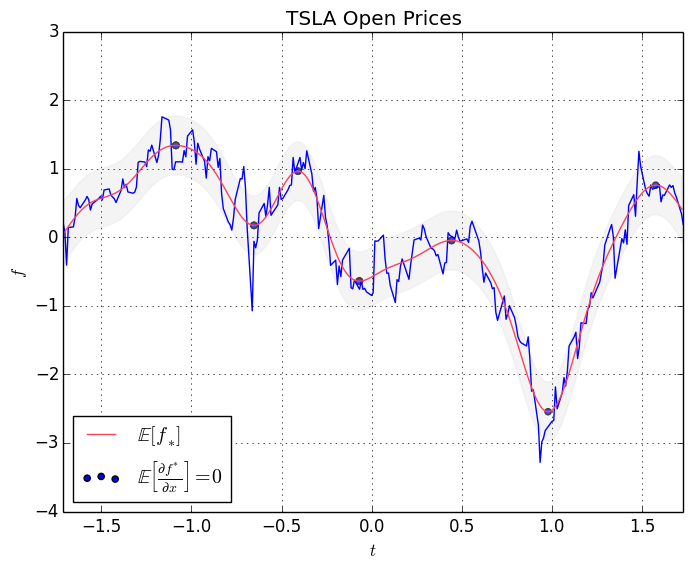

(-1.7101709607151185,1.7265814083171187)

In [33]:
println("==> Plot Results of Critical Point Optimization")

t_opt  = unique(t_opt[!isnan(t_opt)])
f_opt  = K(se, t, t_opt)'*α
∇f_opt = d_K(se, t, t_opt)'*α

plot(t,tsla)
plot(t_, μ, label="\$\\mathbb{E}[f_*]\$", color="#FF425B")
scatter(t_opt, f_opt, label="\$\\mathbb{E}\\left[\\frac{\\partial f^*}{\\partial x}\\right] = 0\$")

fill_between(t_, μ-2σ, μ+2σ, color="#dddddd", alpha=0.3)
title("TSLA Open Prices")
xlabel("\$t\$")
ylabel("\$f\$")
legend(loc="lower left")

grid()
xlim(minimum(t), maximum(t))

### Approximate Generation of Gram Matrix

We note that the kernel matrix $K_y$ and $k_{\star\star}$ are both heavily concentrated on the diagonal. We try to exploit this implicit structure given by sorting our times $t$ prior to constructing the matrix.

In [34]:
plt[:cm][:copper]

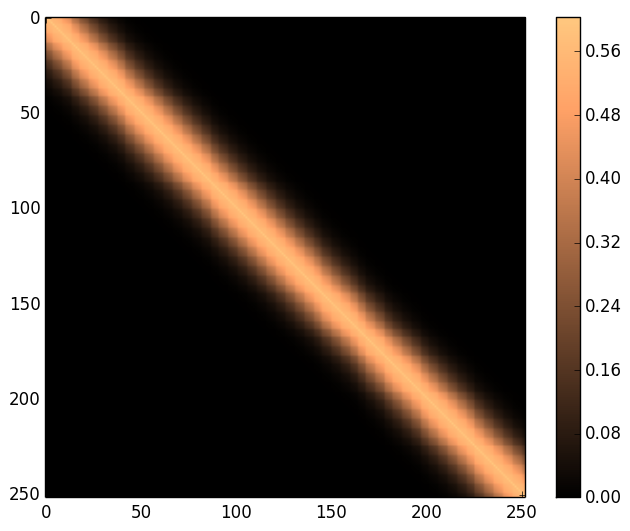

PyObject <matplotlib.colorbar.Colorbar instance at 0x315e158c0>

In [49]:
imshow(K_, cmap=plt[:cm][:copper])
colorbar()

#### Bayesian Optimization of Hyperparameters
(Murphy pp. 523)

We can optimize out the (non-convex) [marginal likelihood](https://en.wikipedia.org/wiki/Marginal_likelihood) of the model by maximizing the $\log$ marginal likelihood. We have

$$
    p(y|X) = \int p(y|f,X)p(f|X)df.
$$

One can show that
$$
    \log p(y|X) = \log \mathcal{N}(y|0,K_y) = -\frac{1}{2}yK_Y^{-1}y - \frac{1}{2}\log|K_y| - \frac{N}{2}\log(2\pi)
$$
and, with the kernel hyperparameters denoted $\theta$,
$$
    \frac{\partial}{\partial \theta_j}\log p(y|X) = \frac{1}{2}\mathrm{tr}\left( (\alpha\alpha^T - K_y^{-1})\frac{\partial K_y}{\partial \theta_j} \right) = \frac{1}{2}\mathrm{tr}\left(A\frac{\partial K_y}{\partial \theta_j}\right).
$$

With this expression for the gradient, we can optimize our hyperparameters in a Bayesian way using any standard gradient-based method like gradient descent.

For the squared exponential kernel in the 1-D case, letting
$$
\begin{align*}
    \theta_1 &= \log(\sigma_f^2)\\
    \theta_2 &= \log(l^2)\\
    \theta_3 &= \log(\sigma_y^2)
\end{align*}
$$
which gives

$$
\begin{align*}
    \kappa(x,x') &= \exp\left(\theta_1 -\frac{1}{2\exp(\theta_2)}(x-x')^2 \right) + \exp(\theta_3)\mathbb{1}\{x=x'\}\\
    \frac{\partial \kappa}{\partial \theta_1} &= \exp\left(\theta_1 -\frac{1}{2\exp(\theta_2)}(x-x')^2 \right)\\
    \frac{\partial \kappa}{\partial \theta_2} &= \frac{1}{2}(x-x')^2 \exp\left(\theta_1 - \theta_2 -\frac{1}{2\exp(\theta_2)}(x-x')^2\right)\\
    \frac{\partial \kappa}{\partial \theta_3} &= \exp(\theta_3)\mathbb{1}\{x=x'\}
\end{align*}
$$

In [12]:
## Perform Gradient Descent on Parameters
## first define gradients
function d_σf(se::SEKernel, X::AbstractArray,X_::AbstractArray)
    K_ = zeros(size(X)[1], size(X_)[1])
    for i=1:size(K_)[1]
        for j=1:size(K_)[2]
            diff = X[i,:] - X_[j,:]
            @inbounds K_[i,j] = exp(se.params[1] - diff'*diff*exp(-se.params[2])/2)[1]
        end
    end
    return K_
end
function d_l(se::SEKernel, X::AbstractArray,X_::AbstractArray)
    K_ = zeros(size(X)[1], size(X_)[1])
    for i=1:size(K_)[1]
        for j=1:size(K_)[2]
            diff = X[i,:] - X_[j,:]
            δ2 = diff'*diff
            @inbounds K_[i,j] = (δ2[1]*exp(se.params[1]-se.params[2] - δ2*exp(-se.params[2])/2))[1]/2
        end
    end
    return K_
end
function d_σy(se::SEKernel, X::AbstractArray,X_::AbstractArray)
    return exp(se.params[3])*eye(size(X)[1], size(X_)[1])
end

# derivs returns a vector and the marginal likelihood
#  (dlogP/dθ, logP)
function derivs(se::SEKernel, X::AbstractArray, y::AbstractVector)
    d_params = zeros(3,1)
    
    # calculate common factors from data
    K_ = K(se, X,X)
    L = chol(K_)
    α = L\(L'\y)
    logP = -y'*α/2 - sum(log(diag(L))) - size(y)[1]*log(2π)/2
    
    L_inv = inv(L)
    A = α*α' - L_inv*L_inv'
    
    d_params[1] = trace(A*d_σf(se,X,X))/2
    d_params[2] = trace(A*d_l(se,X,X))/2
    d_params[3] = trace(A*d_σy(se,X,X))/2
    
    return d_params, logP[1]
end

derivs (generic function with 1 method)

==> logP[25] = -52.200857290348296
 |∇logP| = 3.4215093237926415
==> logP[50] = -51.36911598279008
 |∇logP| = 7.673278322513675
==> logP[75] = -48.1268950333141
 |∇logP| = 17.515497541787393
==> logP[100] = -43.39914177199299
 |∇logP| = 17.0106954844484


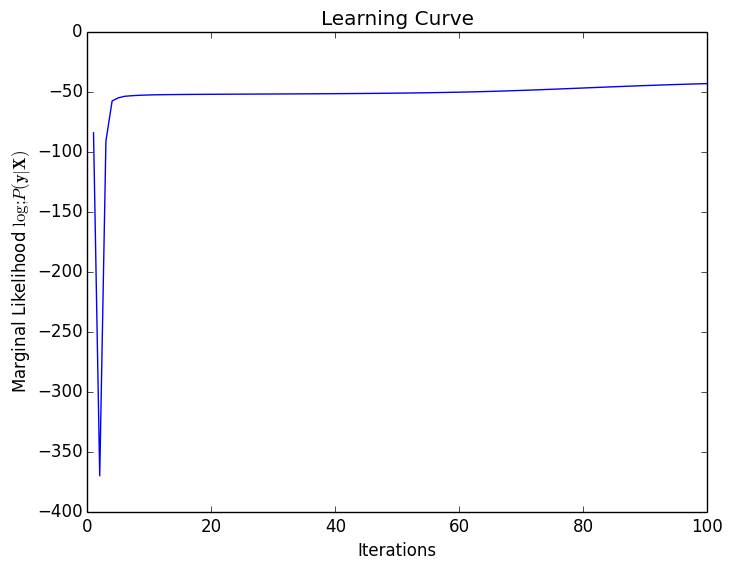

PyObject <matplotlib.text.Text object at 0x31d7cb650>

In [27]:
# run gradient descent

σ = 0.75
l = 0.2
σ_y = 0.2
params = [log(σ^2); log(l^2); log(σ_y^2)]''
# params = randn(3,1) # random instantiation converges much slower!
se = SEKernel(params)

n_iters = 100
lr = 0.05
β = 1.0
∇logP = [0.; 0.; 0.]
logP  = zeros(n_iters)
for i=1:n_iters
    ∇logP, logP[i] = derivs(se, t, tsla)
    
    # we want to maximize logP so we
    # will step `lr/i` in the direction of
    # the graditent
    se.params += (lr/(β*i))*∇logP
    
    if i%25 == 0
        println("==> logP[$(i)] = $(logP[i])\n |∇logP| = $(norm(∇logP))")
    end
end

plot(collect(1:n_iters), logP)
title("Learning Curve")
xlabel("Iterations")
ylabel("Marginal Likelihood \$\\log\; P(\\mathbf{y}|\\mathbf{X})\$")

==> Run GP Regression
--  done.
==> Marginal Likelihood: log P(y|X) = -43.25504806507635
==> Plot Results


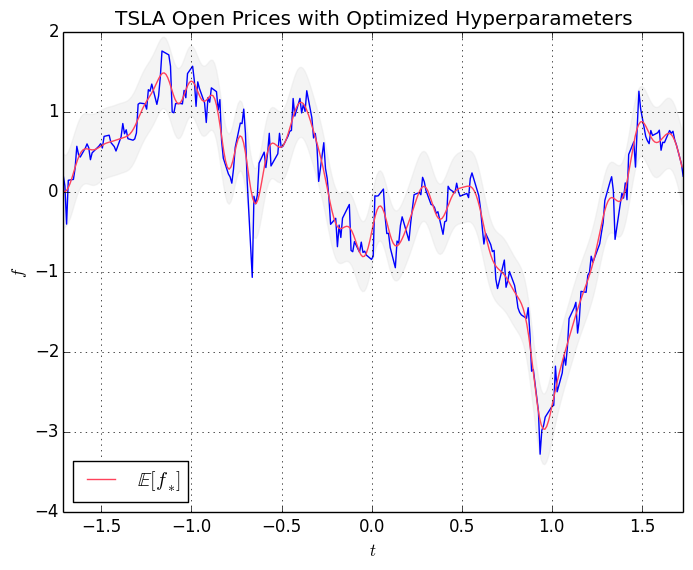

(-1.7101709607151185,1.7265814083171187)

In [28]:
# plot results
K_ = K(se, t, t)

k_ = K(se, t, t_)
dk_ = d_K(se,t,t_)
d2k_ = d2_K(se,t,t_)
k__ = K(se, t_,t_)

println("==> Run GP Regression")
# GP Regression algorithm + derivatives
# -- Machine Learning: A Probabalistic Perspective
#    Kevin Murphy, pp. 526
L = chol(K_)
α = L\(L'\tsla)
μ = k_'*α
v = L'\k_
σ = sqrt(diag(k__) - diag(v'*v))
logP_ = -tsla'*α/2 - sum(log(diag(L))) - size(tsla)[1]*log(2π)/2
println("--  done.")
println("==> Marginal Likelihood: log P(y|X) = $(logP_[1])")

println("==> Plot Results")
plot(t,tsla)
plot(t_, μ, label="\$\\mathbb{E}[f_*]\$", color="#FF425B")
fill_between(t_, μ-2σ, μ+2σ, color="#dddddd", alpha=0.3)
title("TSLA Open Prices with Optimized Hyperparameters")
xlabel("\$t\$")
ylabel("\$f\$")
legend(loc="lower left")

grid()
xlim(minimum(t), maximum(t))

==> Finished (i,j)=(10,10)


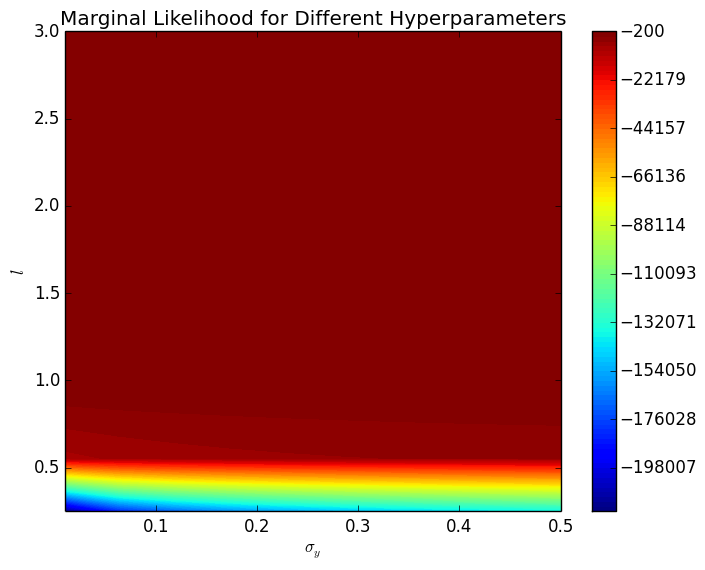

PyObject <matplotlib.colorbar.Colorbar instance at 0x320776440>

In [33]:
## we are going to plot a surface over the
## marginal likelihood to see the nonconvexity

# adapted from https://github.com/gizmaa/Julia_Examples/blob/master/pyplot_surfaceplot.jl

n = 10
σ_y = linspace(0.01,0.5,n)
σ_f = 0.75
l = linspace(0.25,3,n)

σgrid = repmat(σ_y',n,1)
lgrid = repmat(l,1,n)

z = zeros(n,n)

for i in 1:n
    for j in 1:n
        # calculate marginal likelihood for this
        # pair of parameters
        se = SEKernel(σ_f,l[j],σ_y[i])
        
        K_ = K(se, t, t)
        L = chol(K_)
        α = L\(L'\tsla)
        logP = -tsla'*α/2 - sum(log(diag(L))) - size(tsla)[1]*log(2π)/2
        
        z[i:i,j:j] = logP
        
        if j%10 + i%10 == 0
            println("==> Finished (i,j)=($(i),$(j))")
        end
    end
end

cp = plt[:contourf](σgrid, lgrid, z, levels=linspace(minimum(z),maximum(z),100), cmap=plt[:cm][:jet]) 
xlabel("\$\\sigma_y\$") 
ylabel("\$l\$")
title("Marginal Likelihood for Different Hyperparameters")
colorbar()